In [1]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys, string, glob
import torchvision.transforms as transforms
from  collections import defaultdict
from sklearn.linear_model import LassoCV, RidgeCV

strlist = list(string.ascii_lowercase) # storing charaacters from A-Z
%run clean_cornets.py

In [2]:
# Loading word selective stimuli
wordSelUnit = [4,21,23,29,38,41,44,53,59,83,89,92,109,110,115,122,142,146,149,150,152,161,165,166,170, 
              194,197,203,204,210,215,222,226,229,231,232,237,246,250,251,252,254,265,270,282,291,293,294,
              308,315,318,323,351,362,367,372,377,392,407,410,426,430,436,442,451,483,487,507]

In [3]:
# Loading activations for the vinckier stimuli
net = CORNet_Z_nonbiased_words()
checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)

## Vinckier stimuli  
data_dir = 'stimuli/vinckier240/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 80) for x in ['train']}
dataiter = iter(dataloaders['train'])

VnBli = {};  VnBli['h'] = []
for i in range(18):
    stimtemp, classes = next(dataiter)
    _,_,_,_,varh, _ = net(stimtemp.float())
    VnBli['h'].extend(varh.detach().numpy())
    print(i)
    
print('Full Vinckier data loaded')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Full Vinckier data loaded


In [8]:
# Model fitting different categories of Vinckier stimuli

# Response to word specific units
x = np.array(VnBli['h']) #stimulus 
Vli_obs = x[:,wordSelUnit]

# Loading stimuli names
Vwordlist = []; nstimpercat = 240
for file in glob.glob("D:/2_Research/UNICOG/experiments/DNN/Github-Thomas/others/StimulusProperties/*.txt"):
    if not file[-6:-4] == 'NV':
        file1 = open(file,"r") 
        x = (file1.read()).split('\n')
        Vwordlist = np.concatenate((Vwordlist, x[:nstimpercat]))

#  Building regression matrix
Vxmat = np.zeros((len(Vwordlist), 26*8))
for i, seq in enumerate(Vwordlist):
    offset = int(4-len(seq)/2)
    for j, char in enumerate(seq.lower()): 
        if char in strlist:
            pid = (strlist.index(char)*8) + j #+offset # Encoding position information
            Vxmat[i,pid] += 1  # Assigning ones at corresponding locations      
            

    
##### Initializing variables
Vrfit = np.zeros((len(wordSelUnit), 6,6))
coefMat = np.zeros((len(wordSelUnit),6, 26*8))

################ Model fitting  ######################
for neu in range(len(wordSelUnit)): 
# for neu in range(2): 
    print(neu)
    for vcat in range(6):
        Xmat_tr = Vxmat[(vcat)*nstimpercat:(vcat+1)*nstimpercat,:]
        Yobs_tr = Vli_obs[(vcat)*nstimpercat:(vcat+1)*nstimpercat,neu]
        
        reg = LassoCV(cv=5).fit(Xmat_tr, Yobs_tr)   
        coefMat[neu,vcat,:] = reg.coef_

    
        for i in range(6):
            corrval,_ = scipy.stats.pearsonr(Vxmat[(i)*nstimpercat:(i+1)*nstimpercat,:]@reg.coef_, 
                                             Vli_obs[(i)*nstimpercat:(i+1)*nstimpercat,neu])
            Vrfit[neu,vcat,i] = corrval**2 
     
    
# plt.hist(rfit, bins= np.arange(0,1,.1), rwidth= .8, alpha = 0.5)
# plt.hist(Vrfit[:,5],bins = np.arange(0,1,.1),alpha = 0.5, rwidth= .8)
# plt.xlabel('Cross-Validated score (R^2)'); plt.ylabel('Count')
# plt.title('English word selective units - h layer')
# plt.legend(['Trained words','Vinckier words'])

# Ravg = np.append(np.nanmean(Vrfit,0),np.nanmean(rfit))
# plt.figure(2); plt.bar(range(7),Ravg)
# plt.ylabel('Cross-Validated score (R^2)')
# plt.title('English word selective units - h layer')
# plt.xticks(ticks = range(7),labels=['FF','IL','FL','FB','FQ','Vword','500Word']);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


D:\software_installation\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.721757642572356, tolerance: 4.10009166568071
  model = cd_fast.enet_coordinate_descent(


21
22
23
24


D:\software_installation\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.334058703734172, tolerance: 0.26696207103170005
  model = cd_fast.enet_coordinate_descent(
D:\software_installation\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8047498360876659, tolerance: 0.2821287550907665
  model = cd_fast.enet_coordinate_descent(


25


D:\software_installation\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2110851645884395, tolerance: 1.4055298606066284
  model = cd_fast.enet_coordinate_descent(
D:\software_installation\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.111471594258319, tolerance: 1.4055298606066284
  model = cd_fast.enet_coordinate_descent(
D:\software_installation\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6827282681074394, tolerance: 1.4055298606066284
  model = cd_fast.enet_coordinate_descent(
D:\software_installation\Anaconda\lib\site-packages\sklearn\linear_model\_coo

26
27


KeyboardInterrupt: 

In [202]:
# Extracting features of the stimuli
# Lexical properties
%run D:/2_Research/UNICOG/experiments/DNN/Github-Thomas/compute-pseudowords-master_ver20181206/dico.py
lf_avg = []; bf_avg = []; bfall_avg = []; tri_avg = []; quad_avg = [];
for word in Vwordlist:
    stats = compute_stats(word.lower(), mydic)
    lf_avg.append(np.mean(stats['letters']))
    bf_avg.append(np.mean(stats['bigrams']))
    bfall_avg.append(np.mean(stats['allbigrams']))
    tri_avg.append(np.mean(stats['trigrams']))
    quad_avg.append(np.mean(stats['quadrigrams']))



In [10]:
# Saving and loading variables
# import pickle
# with open('nonword_model', 'wb') as f:
#     pickle.dump([Vrfit,coefMat ], f)

# file = open('nonword_model', 'rb')
# data = pickle.load(file)
# file.close()
# Vrfit = data[0]
# coefMat = data[1]

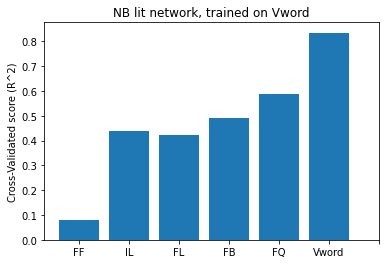

In [65]:
cix= 5
plt.bar(range(6),np.nanmean(Vrfit[:,cix,:],0))
plt.ylabel('Cross-Validated score (R^2)')
plt.title('NB lit network, trained on Vword')
plt.xticks(ticks = range(7),labels=['FF','IL','FL','FB','FQ','Vword']);

Text(0, 0.5, 'Test category')

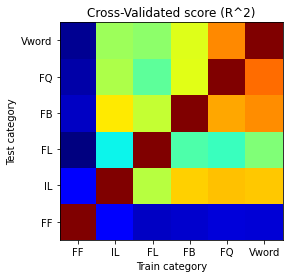

In [22]:
plt.figure(figsize = (4,4)); idx = np.arange(0,.6,0.1)
plt.pcolor(np.nanmean(Vrfit,0),cmap = 'jet', vmax= .75)
plt.xticks(ticks = np.arange(6)+.5,labels=['FF','IL','FL','FB','FQ','Vword']);
plt.yticks(ticks = np.arange(6)+.5,labels=['FF','IL','FL','FB','FQ','Vword']);
plt.title('Cross-Validated score (R^2)')
plt.xlabel('Train category');plt.ylabel('Test category')

D:\software_installation\Anaconda\lib\site-packages\sklearn\manifold\_mds.py:238: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


SpearmanrResult(correlation=0.9272581406323738, pvalue=7.508560730724324e-140)


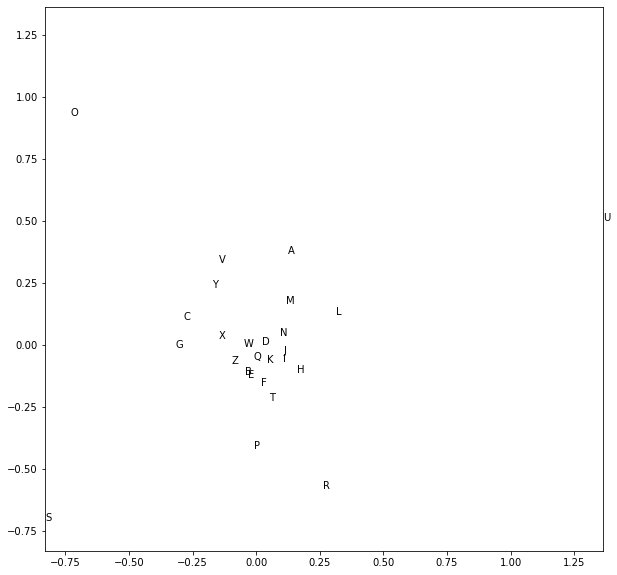

In [99]:
# MDS plot of letter model parameters
 
mean_coef = np.zeros((26,68))
for i in range(68):
    mean_coef[:,i]  = np.mean(np.reshape(coefMat[i,3,:],[26,8]),1)
#     qt = np.reshape(coefMat[i,-1,:],[26,8])
#     mean_coef[:,i]  = qt[:,5]

# tsne visualization with electrodes as features
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
X_pc = PCA(n_components=2).fit_transform(mean_coef)
X_embedded = MDS(n_components=2, metric = False).fit_transform(mean_coef, init = X_pc)
plt.figure(figsize = [10,10])
for i in range(26):
    plt.text(X_embedded[i,0] ,X_embedded[i,1], strlist[i].upper())

lim = [np.min(X_embedded[:]) ,np.max(X_embedded[:])]
plt.xlim(lim);
plt.ylim(lim)

print(scipy.stats.spearmanr(pdist(X_embedded), pdist(mean_coef)))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


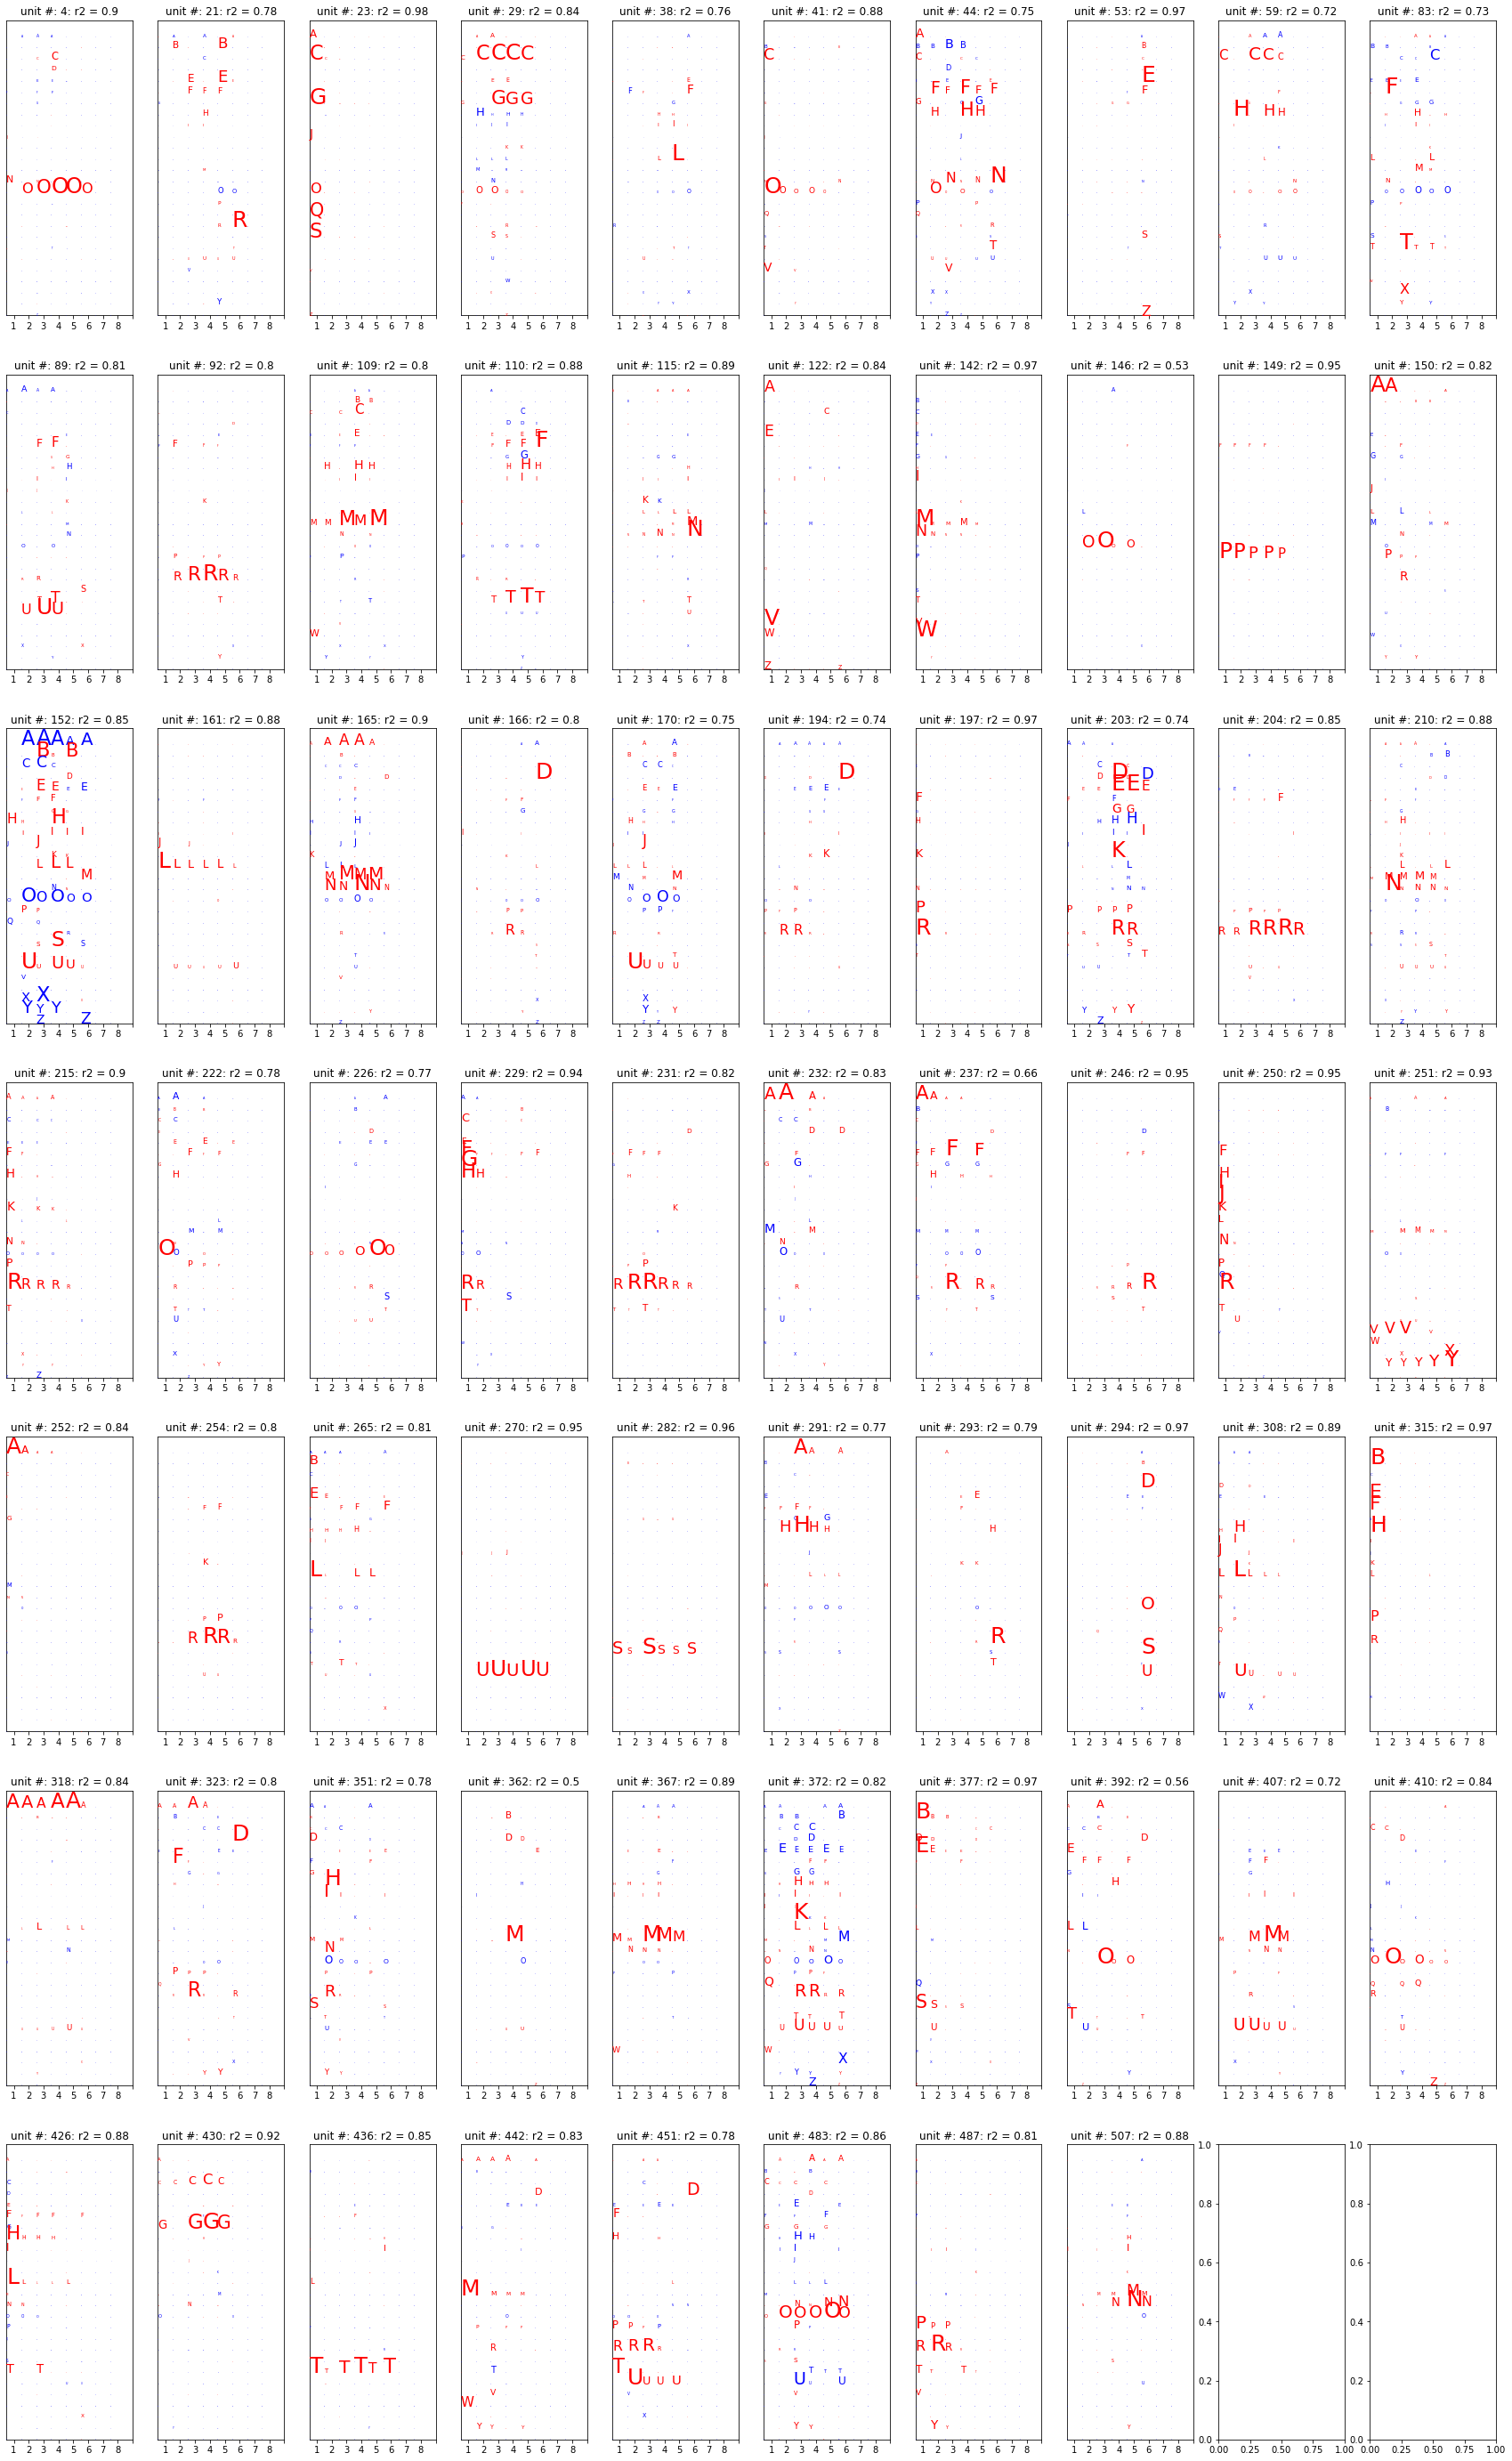

In [102]:
# plotting the receptive field

# sortid = np.argsort(-Vrfit[:,cix,cix]) # Sorting in descending order
visid = np.arange(np.size(Vrfit,0))

# Initializing the variables
max_len = max(map(len, Vwordlist)); 
fig, axs = plt.subplots(7,10, figsize=(30,50), facecolor='w', edgecolor='k')
axs = axs.ravel();
strlist = list(string.ascii_lowercase) # storing charaacters from A-Z


for i,val in enumerate(visid):
    print(val)
    # Visualizing the coefficients
    charcoef = np.reshape(coefMat[i,cix,:],[26,8])
    maxval = np.max(abs(charcoef)); charcoef = charcoef*25/maxval
    for r in range(np.size(charcoef,0)):
        strchar = string.ascii_uppercase[r]
        for c in range(np.size(charcoef,1)):
            strcol = 'red' if charcoef[r,c] >0 else 'blue'
            axs[i].text( c,25-r, strchar, FontSize = abs(charcoef[r,c]), color = strcol)
            axs[i].set_xticks(np.arange(0.5,9,1)); axs[i].set_xticklabels(['1','2','3','4','5','6','7','8']);
#             axs[i].set_xticklabels(['-4','-3','-2','-1','1','2','3','4']);
            axs[i].set_yticks(np.arange(0.5,27,1)); axs[i].set_yticklabels([]);
            axs[i].yaxis.set_ticks_position('none') 


    axs[i].set_title('unit #: ' + str(wordSelUnit[val])+ ': r2 = '+str(round(Vrfit[i,cix,cix],2)))

# plt.savefig("plots/letterRF_figure10.pdf")


<ipython-input-88-ac8eec1f0507>:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(np.mean(diffmat,1));


Text(0, 0.5, 'Mean difference in weight profile')

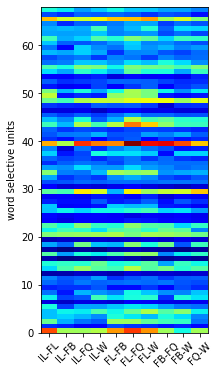

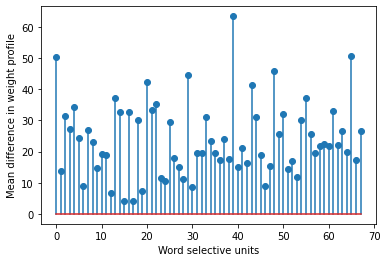

In [88]:
from scipy.spatial.distance import pdist

diffmat = np.zeros((68,10))
for i in range(68):
    diffmat[i,:] = pdist(coefMat[i,1:,:])
    
    
plt.figure(figsize=(3,6))
plt.pcolor(diffmat,cmap = 'jet')
plt.ylabel('word selective units')
plt.xticks(ticks = np.arange(10)+.5,labels=['IL-FL','IL-FB','IL-FQ','IL-W','FL-FB','FL-FQ','FL-W','FB-FQ','FB-W','FQ-W'], rotation = 45);

plt.figure(2)
plt.stem(np.mean(diffmat,1));
plt.xlabel('Word selective units')
plt.ylabel('Mean difference in weight profile')


In [164]:
np.where(np.mean(diffmat,1) > 40)

(array([ 0, 20, 29, 39, 43, 48, 65], dtype=int64),)

1
2
3
4
5


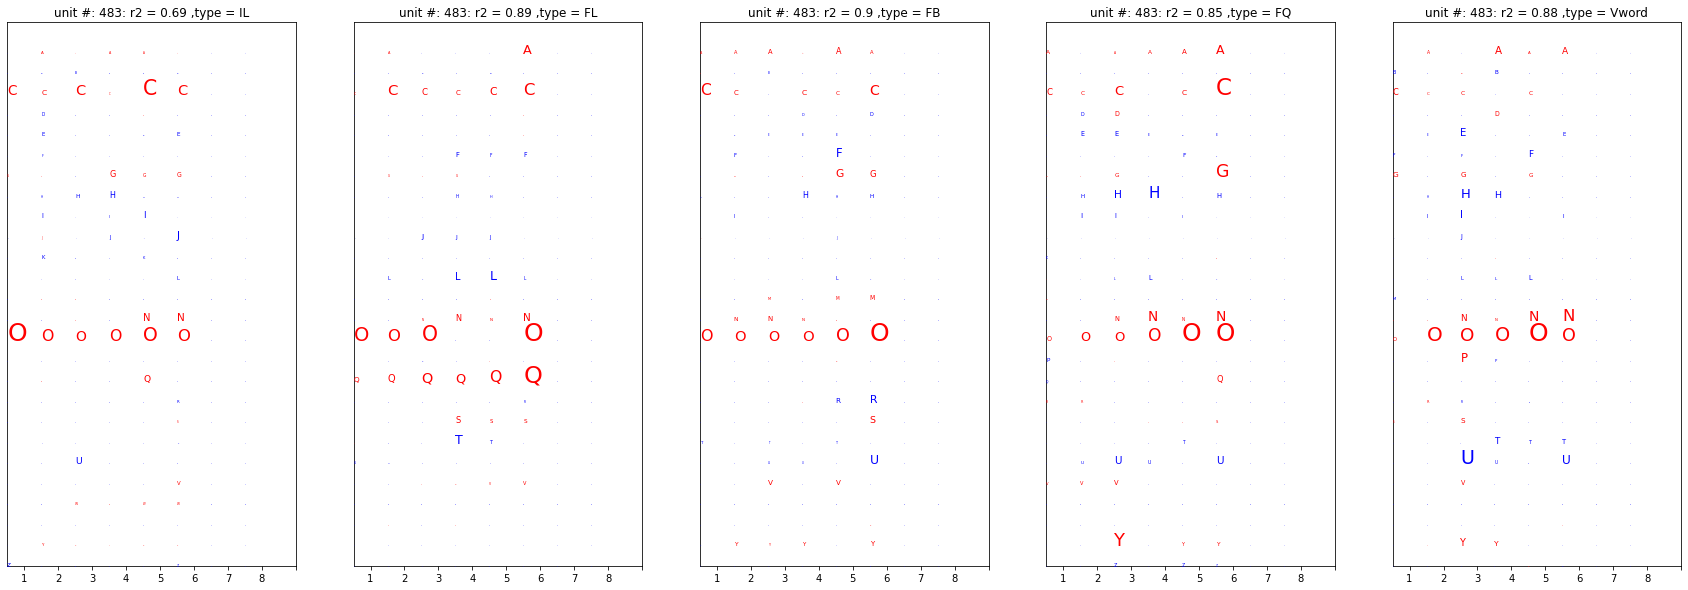

In [171]:
# plotting the receptive field across different categories

# Initializing the variables
max_len = max(map(len, Vwordlist)); 
fig, axs = plt.subplots(1,5, figsize=(30,10), facecolor='w', edgecolor='k')
axs = axs.ravel();
strlist = list(string.ascii_lowercase) # storing charaacters from A-Z
visid = np.arange(1,6); catlabel = ['IL','FL','FB','FQ','Vword']
NID = 65

for i,val in enumerate(visid):
    print(val)
    # Visualizing the coefficients
    charcoef = np.reshape(coefMat[NID,val,:],[26,8])
    maxval = np.max(abs(charcoef)); charcoef = charcoef*25/maxval
    for r in range(np.size(charcoef,0)):
        strchar = string.ascii_uppercase[r]
        for c in range(np.size(charcoef,1)):
            strcol = 'red' if charcoef[r,c] >0 else 'blue'
            axs[i].text( c,25-r, strchar, FontSize = abs(charcoef[r,c]), color = strcol)
            axs[i].set_xticks(np.arange(0.5,9,1)); axs[i].set_xticklabels(['1','2','3','4','5','6','7','8']);
#             axs[i].set_xticklabels(['-4','-3','-2','-1','1','2','3','4']);
            axs[i].set_yticks(np.arange(0.5,27,1)); axs[i].set_yticklabels([]);
            axs[i].yaxis.set_ticks_position('none') 


    axs[i].set_title('unit #: ' + str(wordSelUnit[NID])+ ': r2 = '+str(round(Vrfit[NID,i,i],2)) +' ,type = '+ catlabel[i])

# plt.savefig("plots/letterRF_figure10.pdf")
